## Necessary imports

In [2]:
import math, re, os, sys
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

!pip install -U scikit-learn

print("Tensorflow version " + tf.__version__)

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Tensorflow version 2.12.0


In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    if 'GPU' in tf.test.gpu_device_name():
        print('Running on GPU', tf.test.gpu_device_name())
    else:
        print('Running on CPU')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/

In [4]:
from shutil import rmtree

try:
    rmtree("/kaggle/working/Neural-Networks-2023-Project")
except:
    print('No previous project folder found in working directory.')

! git clone https://github.com/m-tarro/Neural-Networks-2023-Project.git
sys.path.append('/kaggle/working/Neural-Networks-2023-Project/')

from utils.DataLoad import DataLoad
from utils.DataVisualization import DataVisualization

Cloning into 'Neural-Networks-2023-Project'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 44 (delta 16), reused 29 (delta 7), pack-reused 0
Receiving objects: 100% (44/44), 316.73 KiB | 4.06 MiB/s, done.
Resolving deltas: 100% (16/16), done.


# Model to implement

The data will load to data_load based on chosen `IMAGE_SIZE` and `BATCH_SIZE`. Then the model has to be compiled within `strategy.scope()`, compiled with chosen `optimizer`, `loss`, and `metrics`.

In [5]:
def data_augment(image, label):
    #data augmentation to prevent overfitting and to find more patterns.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    #image = tf.image.random_brightness(image, 0.2)
    return image, label

In [6]:
image_size = 224
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

IMAGE_SIZE = [image_size, image_size]

data_load = DataLoad(image_size=image_size, batch_size=BATCH_SIZE)
data_vis = DataVisualization(data_load)

ds_train = data_load.get_training_dataset(data_augment=data_augment)
ds_valid = data_load.get_validation_dataset()
ds_test = data_load.get_test_dataset()

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


In [7]:
"""
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten

gu_seed = tf.keras.initializers.GlorotUniform(seed=1)

with strategy.scope():
    pretrained_model = tf.keras.applications.vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE, 3],
        classes=len(data_load.CLASSES),
        classifier_activation='softmax'
    )
    pretrained_model.trainable = False
    
    for layer in pretrained_model.layers[15:]:
        layer.trainable = True
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])
"""

"\nfrom tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten\n\ngu_seed = tf.keras.initializers.GlorotUniform(seed=1)\n\nwith strategy.scope():\n    pretrained_model = tf.keras.applications.vgg16.VGG16(\n        weights='imagenet',\n        include_top=False,\n        input_shape=[*IMAGE_SIZE, 3],\n        classes=len(data_load.CLASSES),\n        classifier_activation='softmax'\n    )\n    pretrained_model.trainable = False\n    \n    for layer in pretrained_model.layers[15:]:\n        layer.trainable = True\n    \n    model = tf.keras.Sequential([\n        pretrained_model,\n        tf.keras.layers.GlobalAveragePooling2D(),\n        tf.keras.layers.BatchNormalization(),  \n        tf.keras.layers.Dropout(0.25),\n        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')\n    ])\n"

In [8]:
from tensorflow.keras import layers, callbacks

with strategy.scope():
#     pretrained_model = tf.keras.applications.InceptionResNetV2(
#     weights = 'imagenet', 
#     include_top = False, 
#     input_shape = [*IMAGE_SIZE, 3])

#     pretrained_model = tf.keras.applications.MobileNetV2(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = tf.keras.applications.ResNet152V2(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = tf.keras.applications.InceptionV3(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = efficientnet.EfficientNetB7(
#         weights = 'noisy-student', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
    pretrained_model = tf.keras.applications.DenseNet201(
        weights = 'imagenet', 
        include_top = False, 
        input_shape = [*IMAGE_SIZE, 3])
        
#     pretrained_model = tf.keras.applications.xception.Xception(
#         weights='imagenet',
#         include_top=False ,
#         input_shape=[*IMAGE_SIZE, 3]
#     )

    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([        
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

74836368/74836368 [==============================] - 1s 0us/step


In [9]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model_name = 'densenet201_minAug'

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 104)               199784    
                                                                 
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


Now it is possible to augment the images within `data_augment` function, pick the number of `EPOCHS`, and fit the model.

### Augmentation visualisation

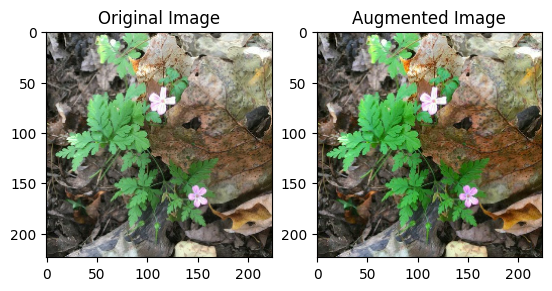

In [10]:
from itertools import islice
import matplotlib.pyplot as plt

ds_train_original = data_load.get_training_dataset(data_augment = False, ordered = True)
ds_train_no_augment = ds_train_original.take(1).cache().repeat()
ds_train_augment = ds_train_no_augment.map(data_augment)

index = 1 # Use the same index for both datasets
augmented_images, labels = next(islice(ds_train_augment, index, None))
original_images, labels = next(islice(ds_train_no_augment, index, None))

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(original_images[0].numpy())
axes[0].set_title("Original Image")
axes[1].imshow(augmented_images[0].numpy())
axes[1].set_title("Augmented Image")
plt.show()

## Training

In [12]:
EPOCHS = 30
STEPS_PER_EPOCH = data_load.TRAINING_STEPS_PER_EPOCH

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    #callbacks=[lr_callback, early_stopping],
    callbacks=[early_stopping]
    #class_weight = weight_per_class #tuning11
)

Epoch 1/30


2023-05-12 15:06:39.170172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-12 15:06:41.682814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - ETA: 0s - loss: 1.5931 - sparse_categorical_accuracy: 0.6163

2023-05-12 15:09:04.339328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-12 15:09:04.867166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 258s 557ms/step - loss: 1.5931 - sparse_categorical_accuracy: 0.6163 - val_loss: 2.5957 - val_sparse_categorical_accuracy: 0.3790
Epoch 2/30
99/99 [==============================] - 24s 247ms/step - loss: 0.6952 - sparse_categorical_accuracy: 0.8155 - val_loss: 1.7484 - val_sparse_categorical_accuracy: 0.5822
Epoch 3/30
99/99 [==============================] - 24s 244ms/step - loss: 0.4793 - sparse_categorical_accuracy: 0.8718 - val_loss: 1.1734 - val_sparse_categorical_accuracy: 0.7093
Epoch 4/30
99/99 [==============================] - 25s 256ms/step - loss: 0.3522 - sparse_categorical_accuracy: 0.9024 - val_loss: 1.1049 - val_sparse_categorical_accuracy: 0.7430
Epoch 5/30
99/99 [==============================] - 21s 215ms/step - loss: 0.3033 - sparse_categorical_accuracy: 0.9136 - val_loss: 1.3732 - val_sparse_categorical_accuracy: 0.6767
Epoch 6/30
99/99 [==============================] - 24s 244ms/step - loss: 0.2263 - sparse_categorical_ac

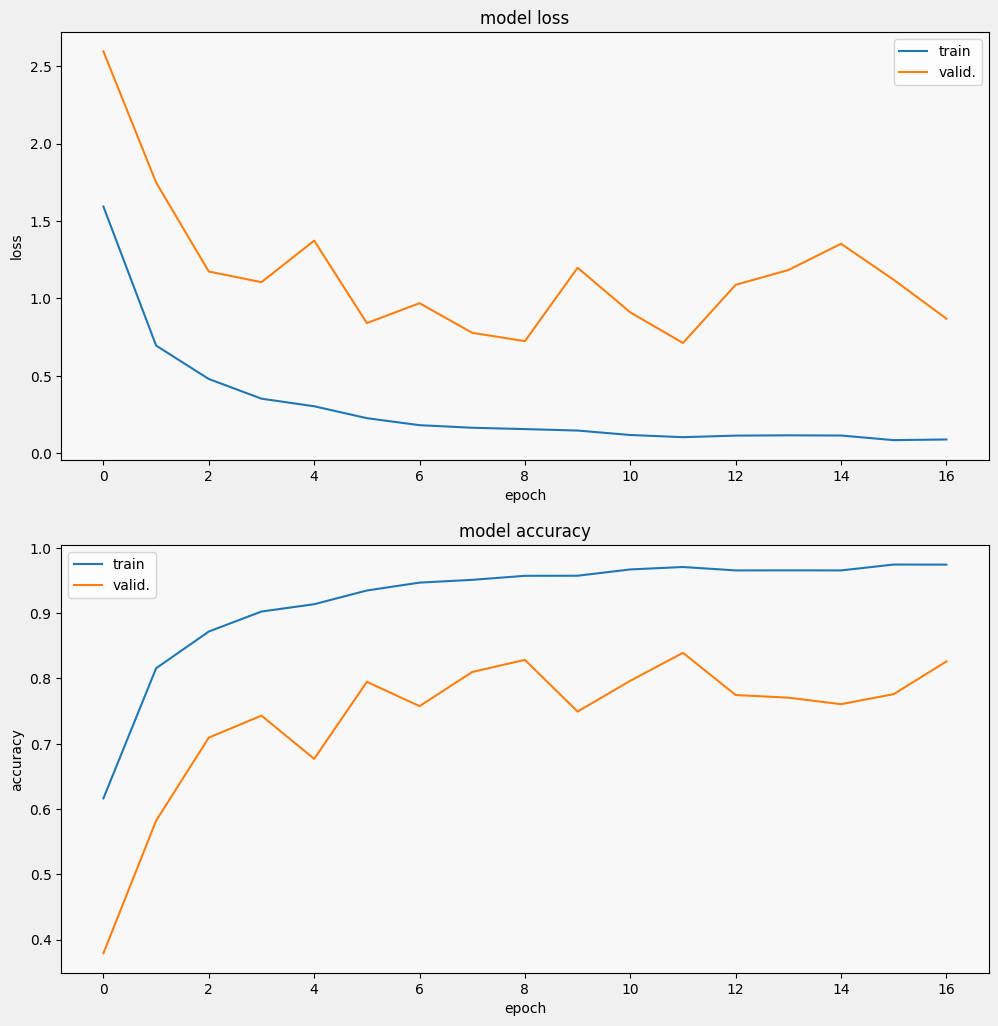

In [14]:
data_vis.display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211
)
data_vis.display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212
)

In [16]:
np.save(f'history_{model_name}.npy',history.history)
model.save(f'model_{model_name}.h5')

## Confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix

# Load validation dataset from DataLoad object
cmdataset = data_load.get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

# Get correct labels and model predictions
cm_correct_labels = next(iter(labels_ds.batch(data_load.NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

# Compute confusion matrix and normalize
labels = range(len(data_load.CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T


2023-05-12 15:20:33.964135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-12 15:20:34.459259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


29/29 [==============================] - 28s 80ms/step


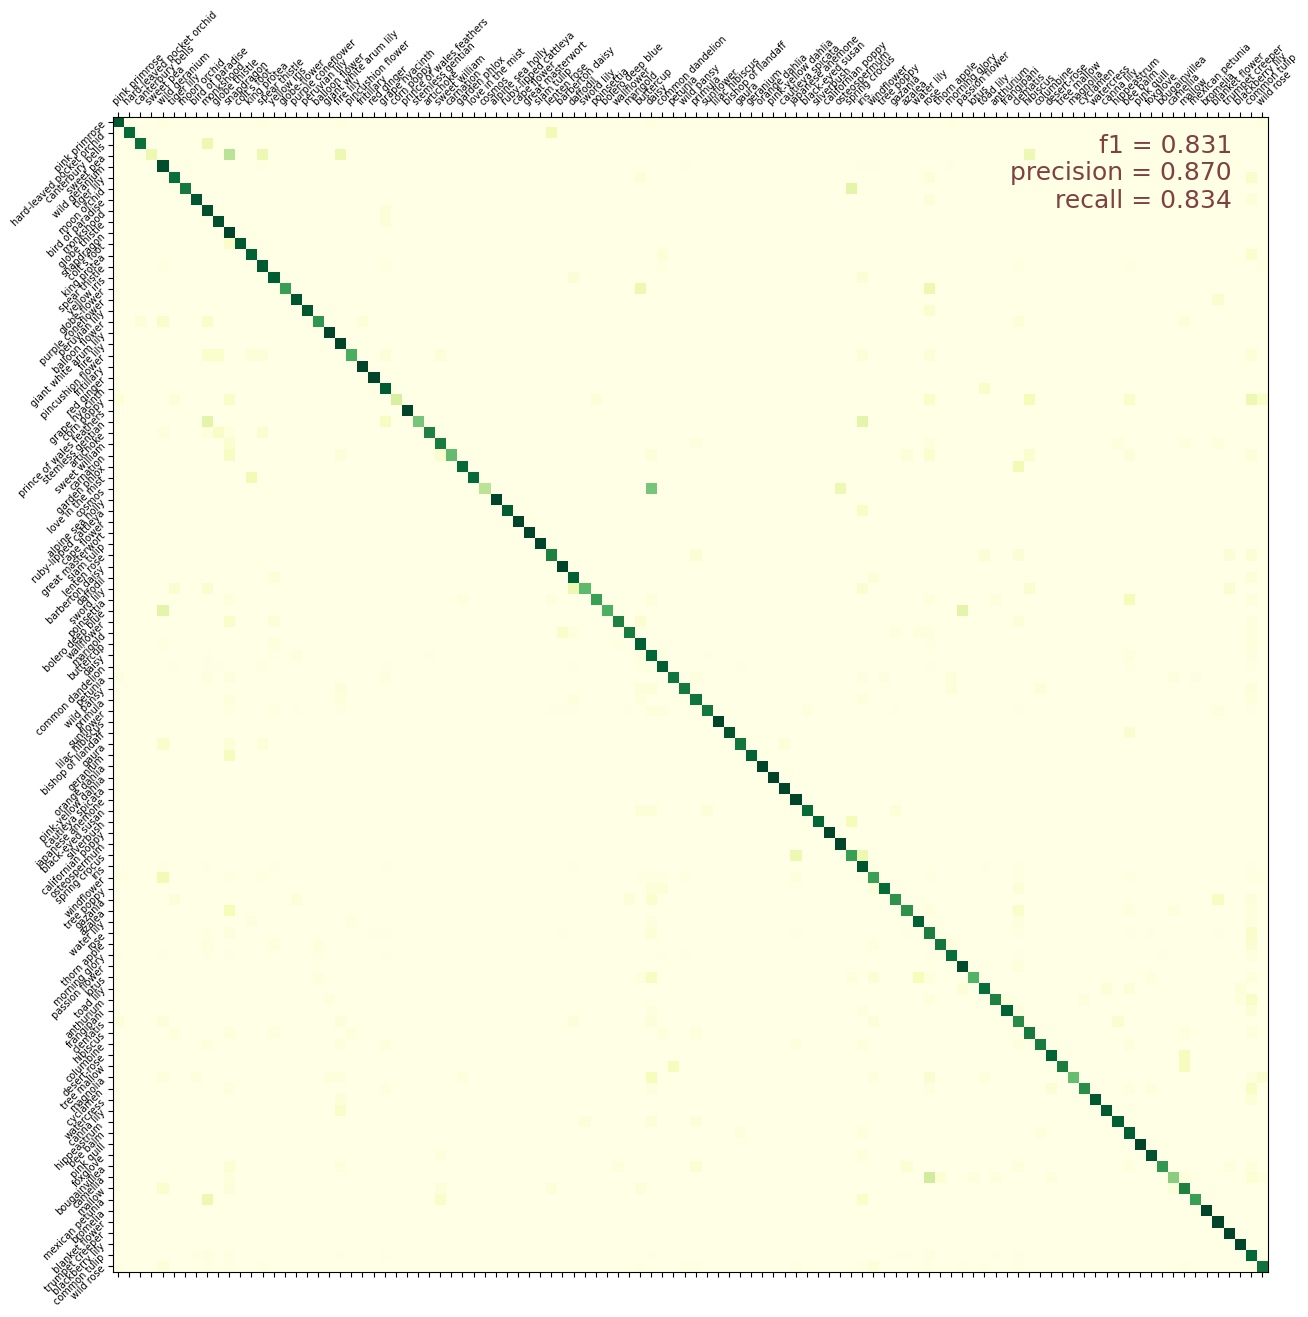

In [19]:

from sklearn.metrics import f1_score, precision_score, recall_score

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
data_vis.display_confusion_matrix(cmat, score, precision, recall)


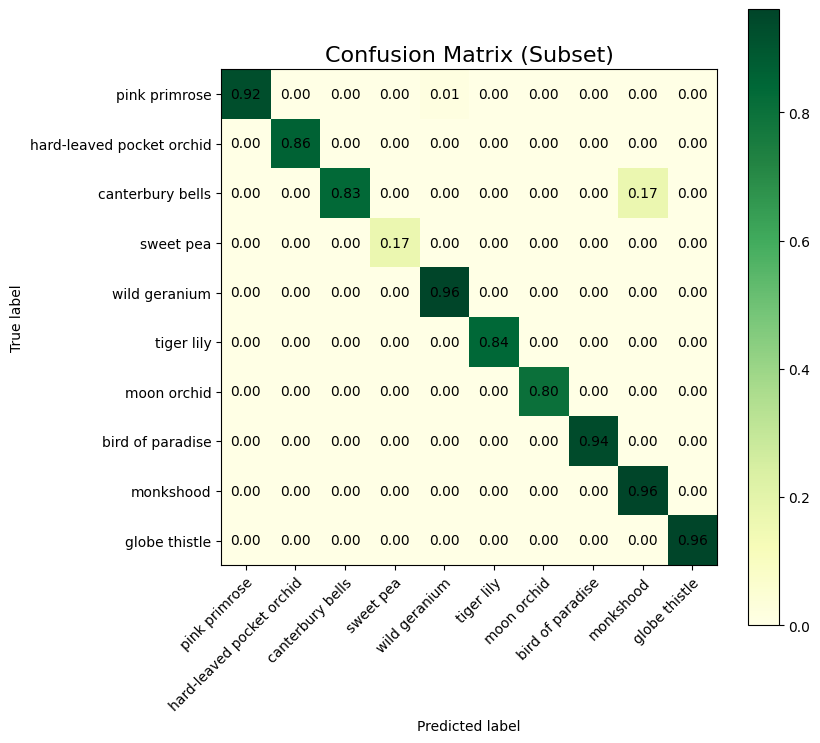

In [20]:

#Since the entire matrix is too large to be visualised at once I made an example subset of it

# Define class names
class_names = data_load.CLASSES[:10]

# Get confusion matrix for first 10 classes
cmat_subset = cmat[:10, :10]

# Normalize confusion matrix
#cmat_subset = (cmat_subset.T / cmat_subset.sum(axis=1)).T

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cmat_subset, cmap='YlGn')

# Show all ticks
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))

# Label ticks with class names
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Axis names
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, "{:.2f}".format(cmat_subset[i, j]),
                       ha="center", va="center", color="black")

# Set plot title and colorbar
ax.set_title("Confusion Matrix (Subset)", fontsize=16)
plt.colorbar(im)
plt.show()


## Visual validation

In [21]:

dataset = cmdataset.unbatch().batch(20)
batch = iter(dataset)


1/1 [==============================] - 0s 497ms/step


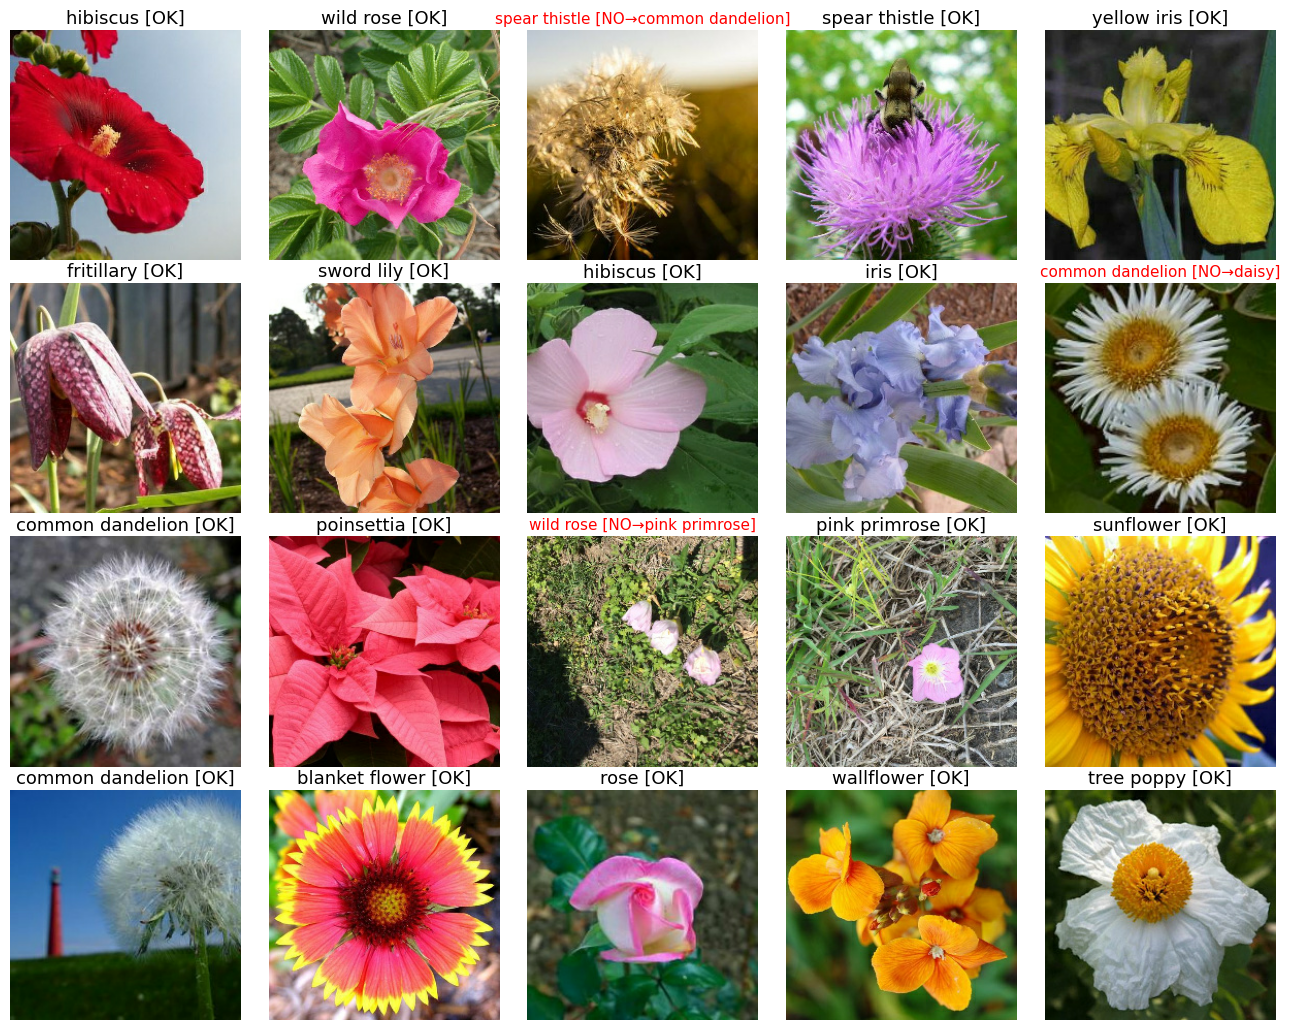

In [23]:

images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
data_vis.display_batch_of_images((images, labels), predictions)


# Predictions to submit

In [24]:
print('Computing predictions...')
test_images_ds = ds_test.map(lambda image, idnum: image).batch(BATCH_SIZE)
probabilities = model.predict(test_images_ds, steps=data_load.TEST_STEPS_PER_EPOCH+1)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
58/58 [==============================] - 5s 81ms/step
[ 4 96 79 ... 36 10 74]


In [25]:
print('Generating submission.csv file...')
test_ids_ds = ds_test.map(lambda image, idnum: idnum)
test_ids = next(iter(test_ids_ds.batch(data_load.NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt(f'submission_{model_name}.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Generating submission.csv file...


# Submitting

If you haven't already, create your own editable copy of this notebook by clicking on the Copy and Edit button in the top right corner. Then, submit to the competition by following these steps:

1. Begin by clicking on the blue Save Version button in the top right corner of the window. This will generate a pop-up window.
2. Ensure that the Save and Run All option is selected, and then click on the blue Save button.
3. This generates a window in the bottom left corner of the notebook. After it has finished running, click on the number to the right of the Save Version button. This pulls up a list of versions on the right of the screen. Click on the ellipsis (...) to the right of the most recent version, and select Open in Viewer. This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the Output tab on the right of the screen. Then, click on the file you would like to submit, and click on the blue Submit button to submit your results to the leaderboard.

You have now successfully submitted to the competition!